In [1]:
from tensorflow.python.ops.gen_dataset_ops import iterator_get_next_as_optional
%load_ext autoreload
%autoreload 2

import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow info messages

print(sys.version)

import tensorflow as tf
print(tf.__version__)

from src.preprocessing import *
from src.display import *
from src.training import *

import math

2024-10-06 16:50:31.170011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 16:50:31.200852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 16:50:31.208425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 16:50:31.236120: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 16:50:32.319623: W tensorflow/compiler/tf2

3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:12:24) [GCC 11.2.0]
2.17.0


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1728226234.388600  160635 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:25:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728226234.424671  160635 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:25:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728226234.424734  160635 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:25:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
train_folder = "data/train"
val_folder = "data/validation"

nii_images_train = list_nii_files(train_folder, 'Flair-Brain.nii')
nii_masks_train = list_nii_files(train_folder, 'LesionSeg-Flair.nii')
nii_images_val = list_nii_files(val_folder, 'Flair-Brain.nii')
nii_masks_val = list_nii_files(val_folder, 'LesionSeg-Flair.nii')


In [4]:
images_train = load_all_data(nii_images_train)
masks_train = load_all_data(nii_masks_train)
images_val = load_all_data(nii_images_val)
masks_val = load_all_data(nii_masks_val)

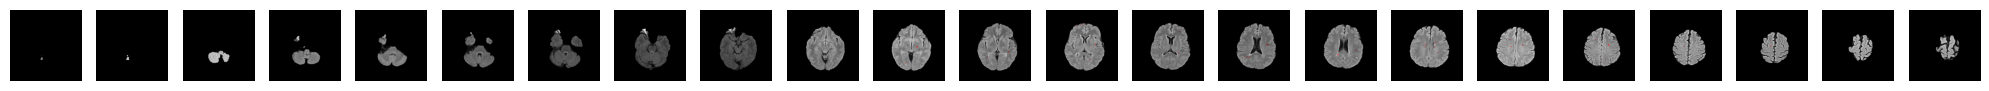

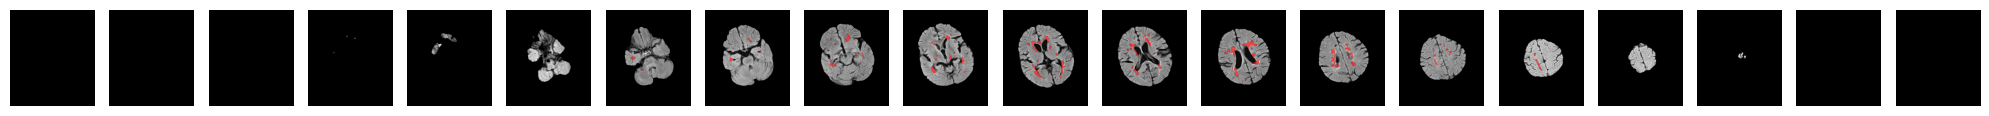

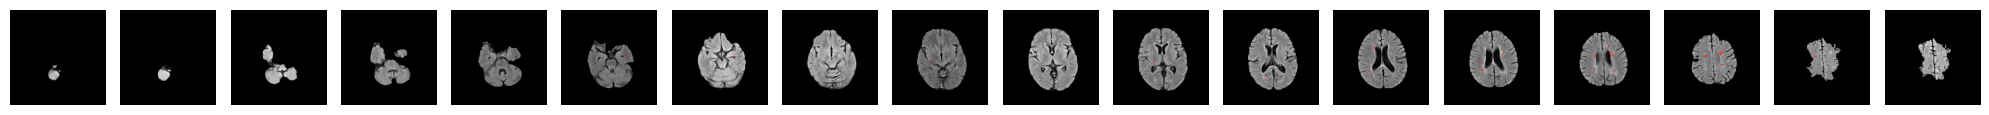

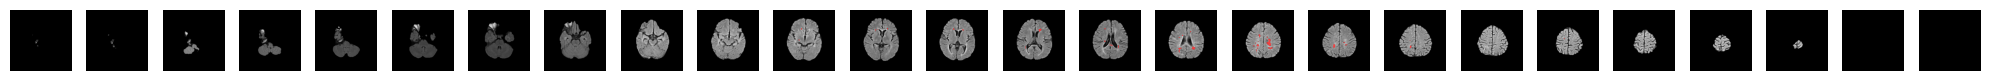

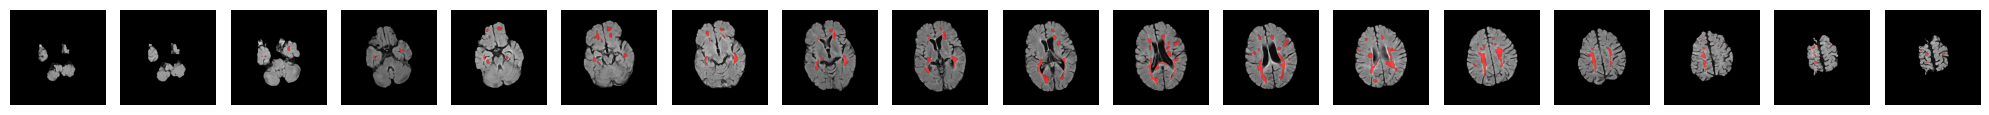

In [5]:
for i, (image, mask) in enumerate(zip(images_train[:5], masks_train[:5])):
    display_image(image, mask, rows=1)

In [6]:
resized_images_train = resize_all_images(images_train)
resized_masks_train = resize_all_images(masks_train)

resized_images_val = resize_all_images(images_val)
resized_masks_val = resize_all_images(masks_val)

# assert that the shapes are the same in mask and scan (x and y dimensions)
# for image, mask in zip(resized_images_train, resized_masks_train):
#     assert image.shape[:-1] == mask.shape[:-1]

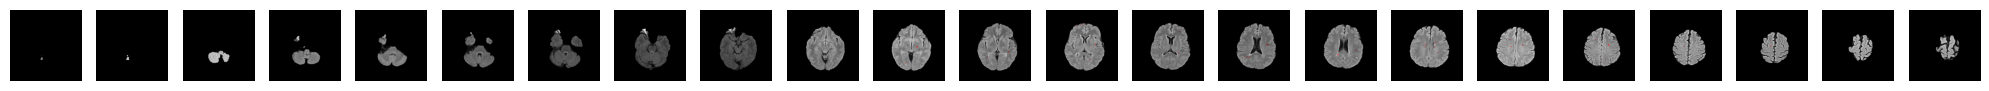

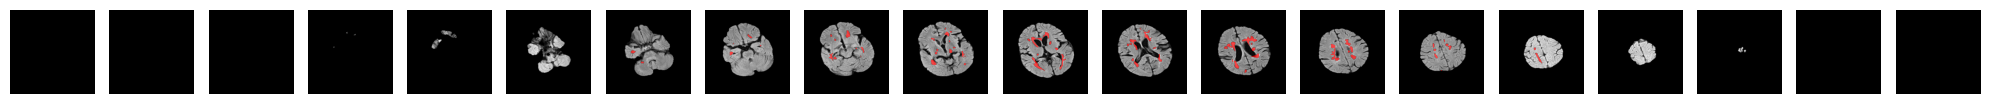

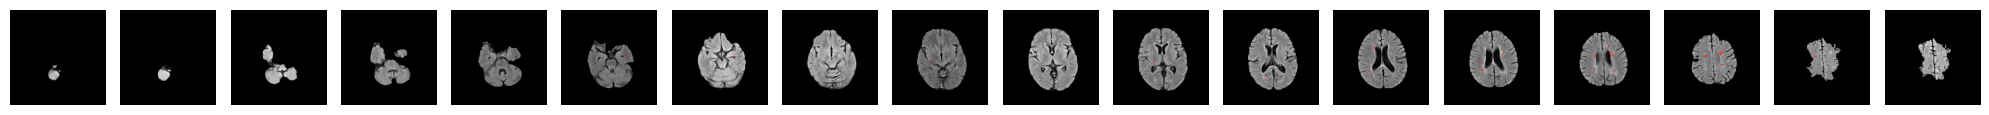

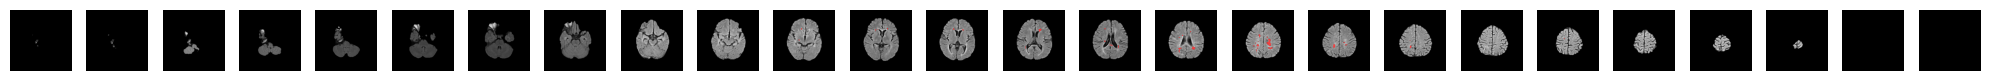

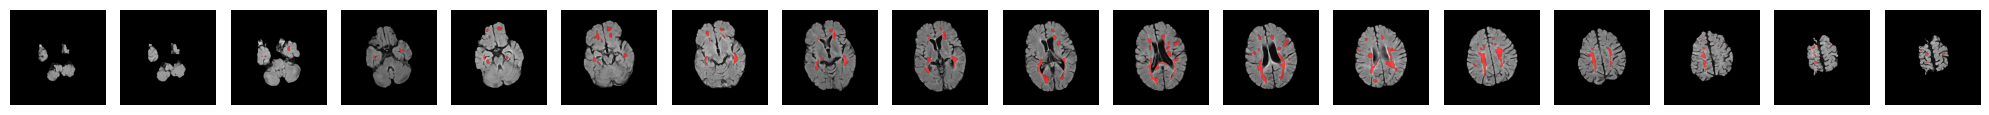

In [7]:
for i, (image, mask) in enumerate(zip(resized_images_train[:5], resized_masks_train[:5])):
    display_image(image, mask, rows=1)

In [8]:
normalized_images_train = normalize_images(resized_images_train)
normalized_images_val = normalize_images(resized_images_val)

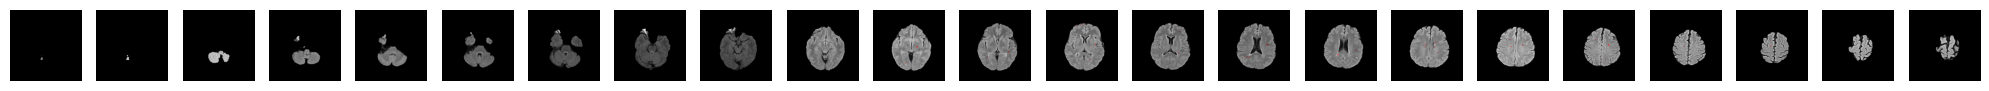

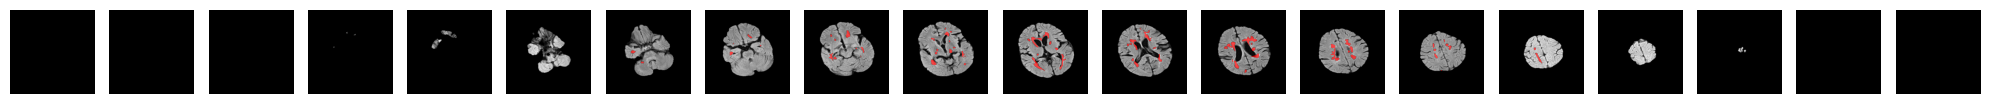

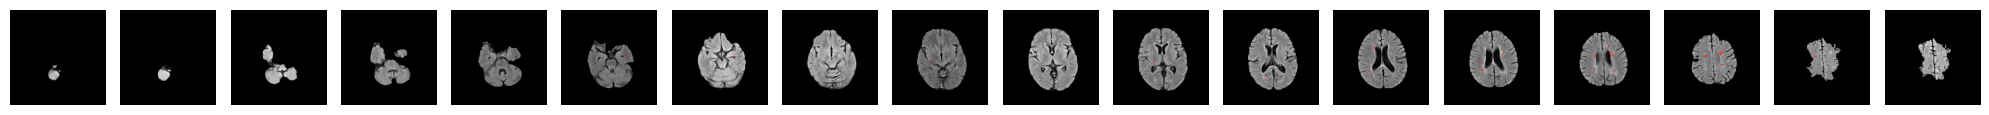

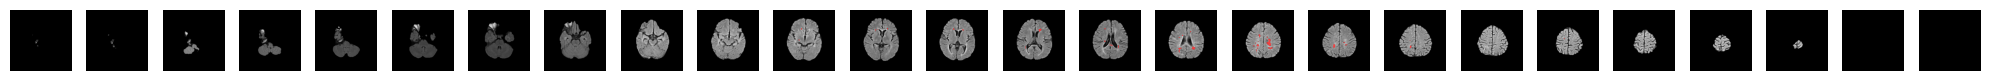

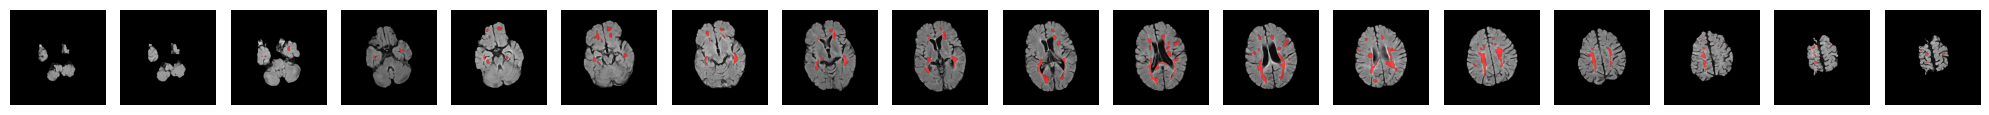

In [9]:
for i, (image, mask) in enumerate(zip(normalized_images_train[:5], resized_masks_train[:5])):
    display_image(image, mask, rows=1)

In [10]:
# Keep only slices that contain lesions
filtered_images_train, filtered_masks_train = filter_slices_with_lesions(normalized_images_train, resized_masks_train)
filtered_images_val, filtered_masks_val = filter_slices_with_lesions(resized_images_val, resized_masks_val)

# Output the number of slices remaining for each scan after filtering
for i, (filtered_image_train, filtered_mask_train) in enumerate(zip(filtered_images_train, filtered_masks_train)):
    print(f"Scan {i + 1}: {filtered_image_train.shape[-1]} slices remaining, corresponding mask shape: {filtered_mask_train.shape}")

Scan 1: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 2: 10 slices remaining, corresponding mask shape: (256, 256, 10)
Scan 3: 12 slices remaining, corresponding mask shape: (256, 256, 12)
Scan 4: 10 slices remaining, corresponding mask shape: (256, 256, 10)
Scan 5: 16 slices remaining, corresponding mask shape: (256, 256, 16)
Scan 6: 12 slices remaining, corresponding mask shape: (256, 256, 12)
Scan 7: 7 slices remaining, corresponding mask shape: (256, 256, 7)
Scan 8: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 9: 4 slices remaining, corresponding mask shape: (256, 256, 4)
Scan 10: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 11: 14 slices remaining, corresponding mask shape: (256, 256, 14)
Scan 12: 7 slices remaining, corresponding mask shape: (256, 256, 7)
Scan 13: 19 slices remaining, corresponding mask shape: (256, 256, 19)
Scan 14: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 15: 12 slices re

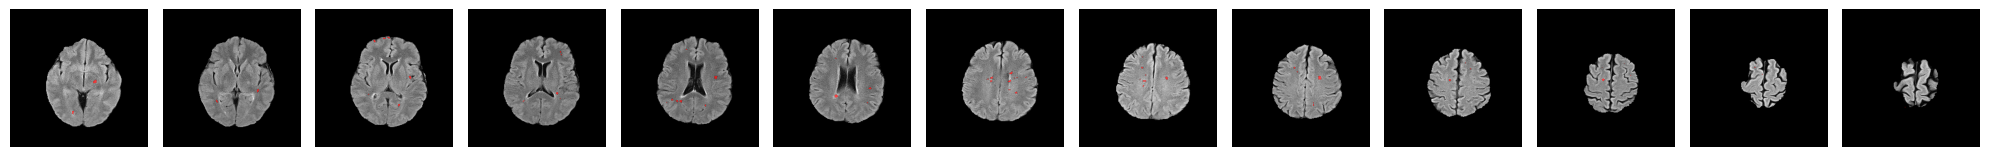

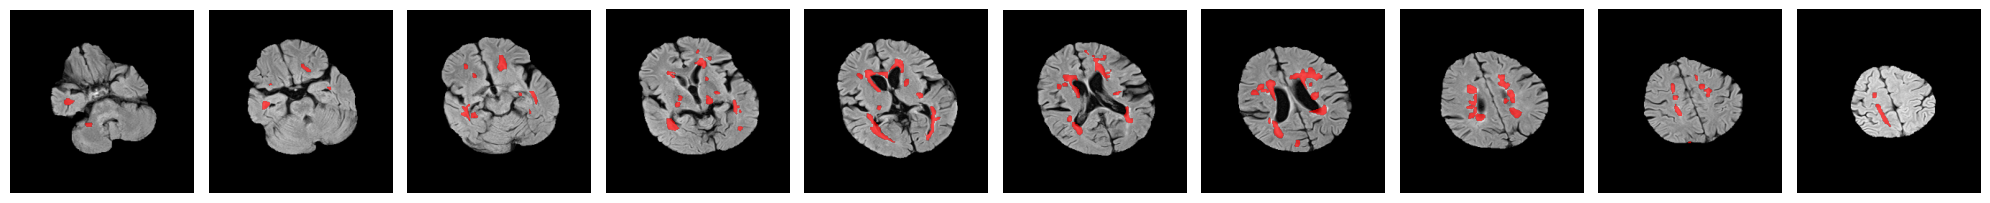

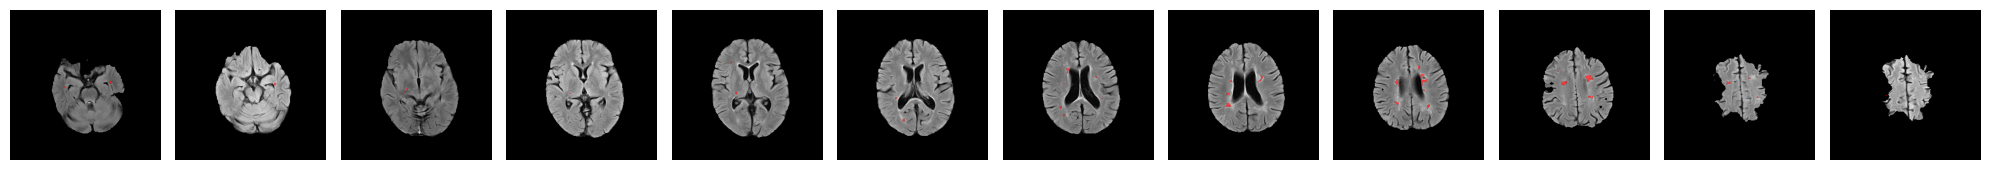

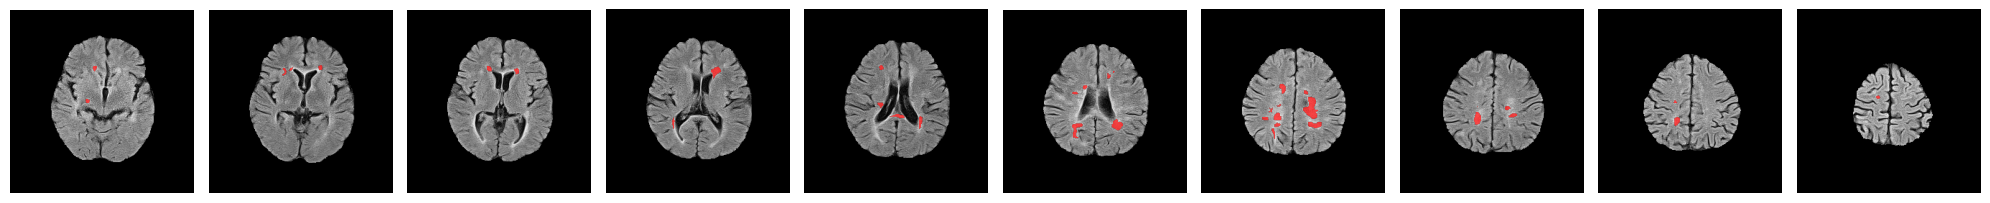

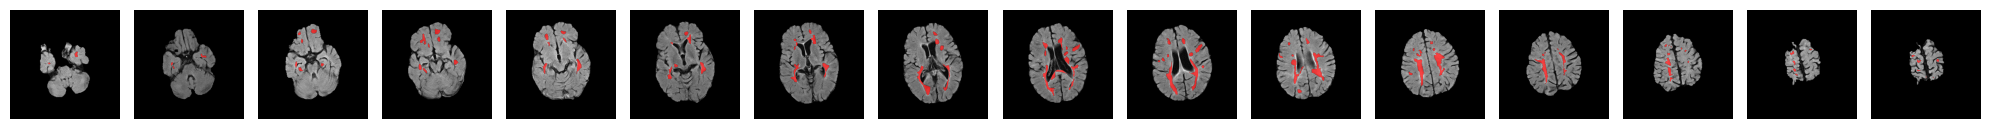

In [11]:
for i, (image, mask) in enumerate(zip(filtered_images_train[:5], filtered_masks_train[:5])):
    display_image(image, mask, rows=1)

In [12]:
# Stack 2D slices from all images
all_slices_train = stack_slices(filtered_images_train)
all_masks_train = stack_slices(filtered_masks_train)
all_slices_val = stack_slices(filtered_images_val)
all_masks_val = stack_slices(filtered_masks_val)

# Data Augmentation 

In [13]:
SEED = 1 # Seed to ensure the same augmentation is applied to both image and mask
BATCH_SIZE = 32

# Flow from memory
slice_iterator_train = get_augment_data_generator().flow(all_slices_train, seed=SEED, batch_size=BATCH_SIZE)
mask_iterator_train = get_augment_data_generator().flow(all_masks_train, seed=SEED, batch_size=BATCH_SIZE)

# Combined generator
iterator_train = get_combined_iterator(slice_iterator_train, mask_iterator_train)

# We probably don't want to augment the validation data?
slice_iterator_val = ImageDataGenerator().flow(all_slices_val, seed=SEED, batch_size=BATCH_SIZE)
mask_iterator_val = ImageDataGenerator().flow(all_masks_val, seed=SEED, batch_size=BATCH_SIZE)

iterator_val = get_combined_iterator(slice_iterator_val, mask_iterator_val)

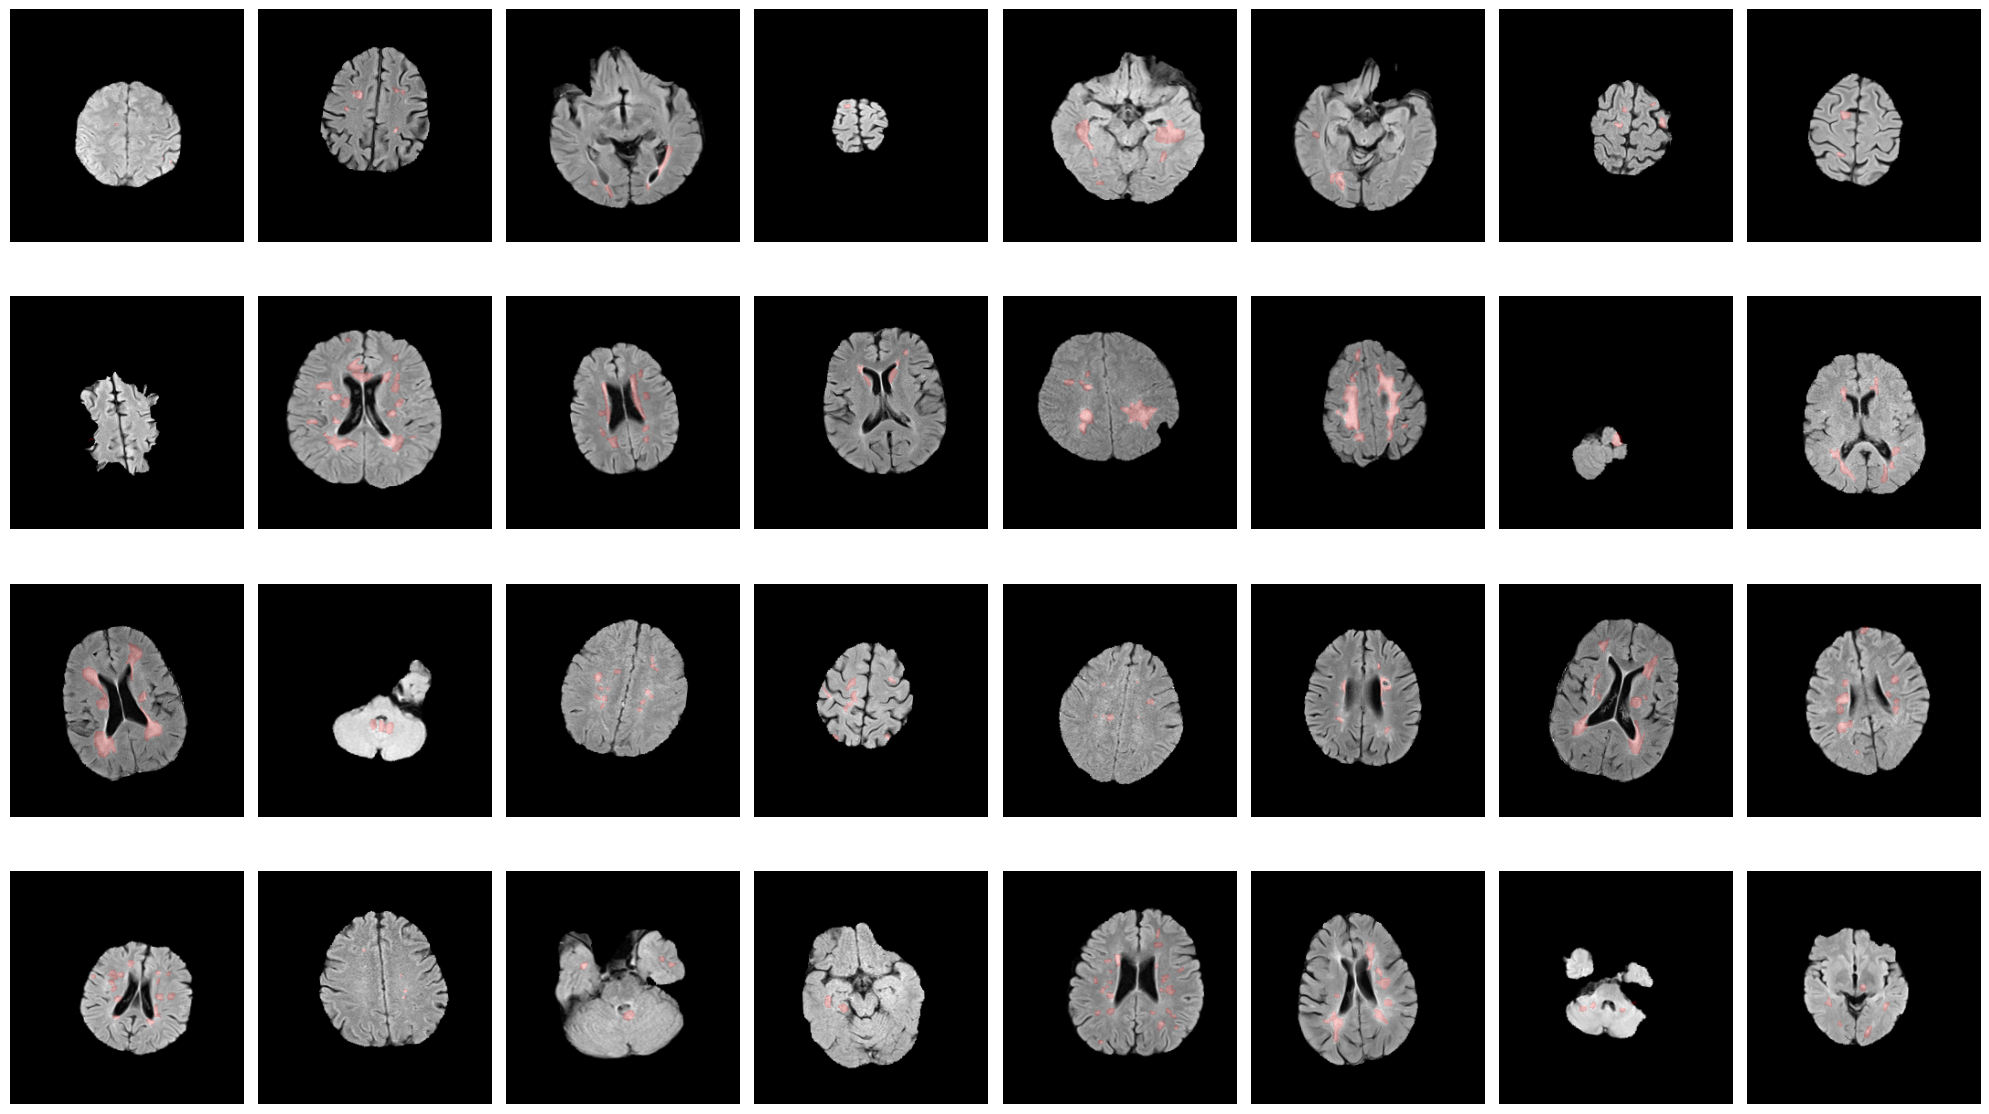

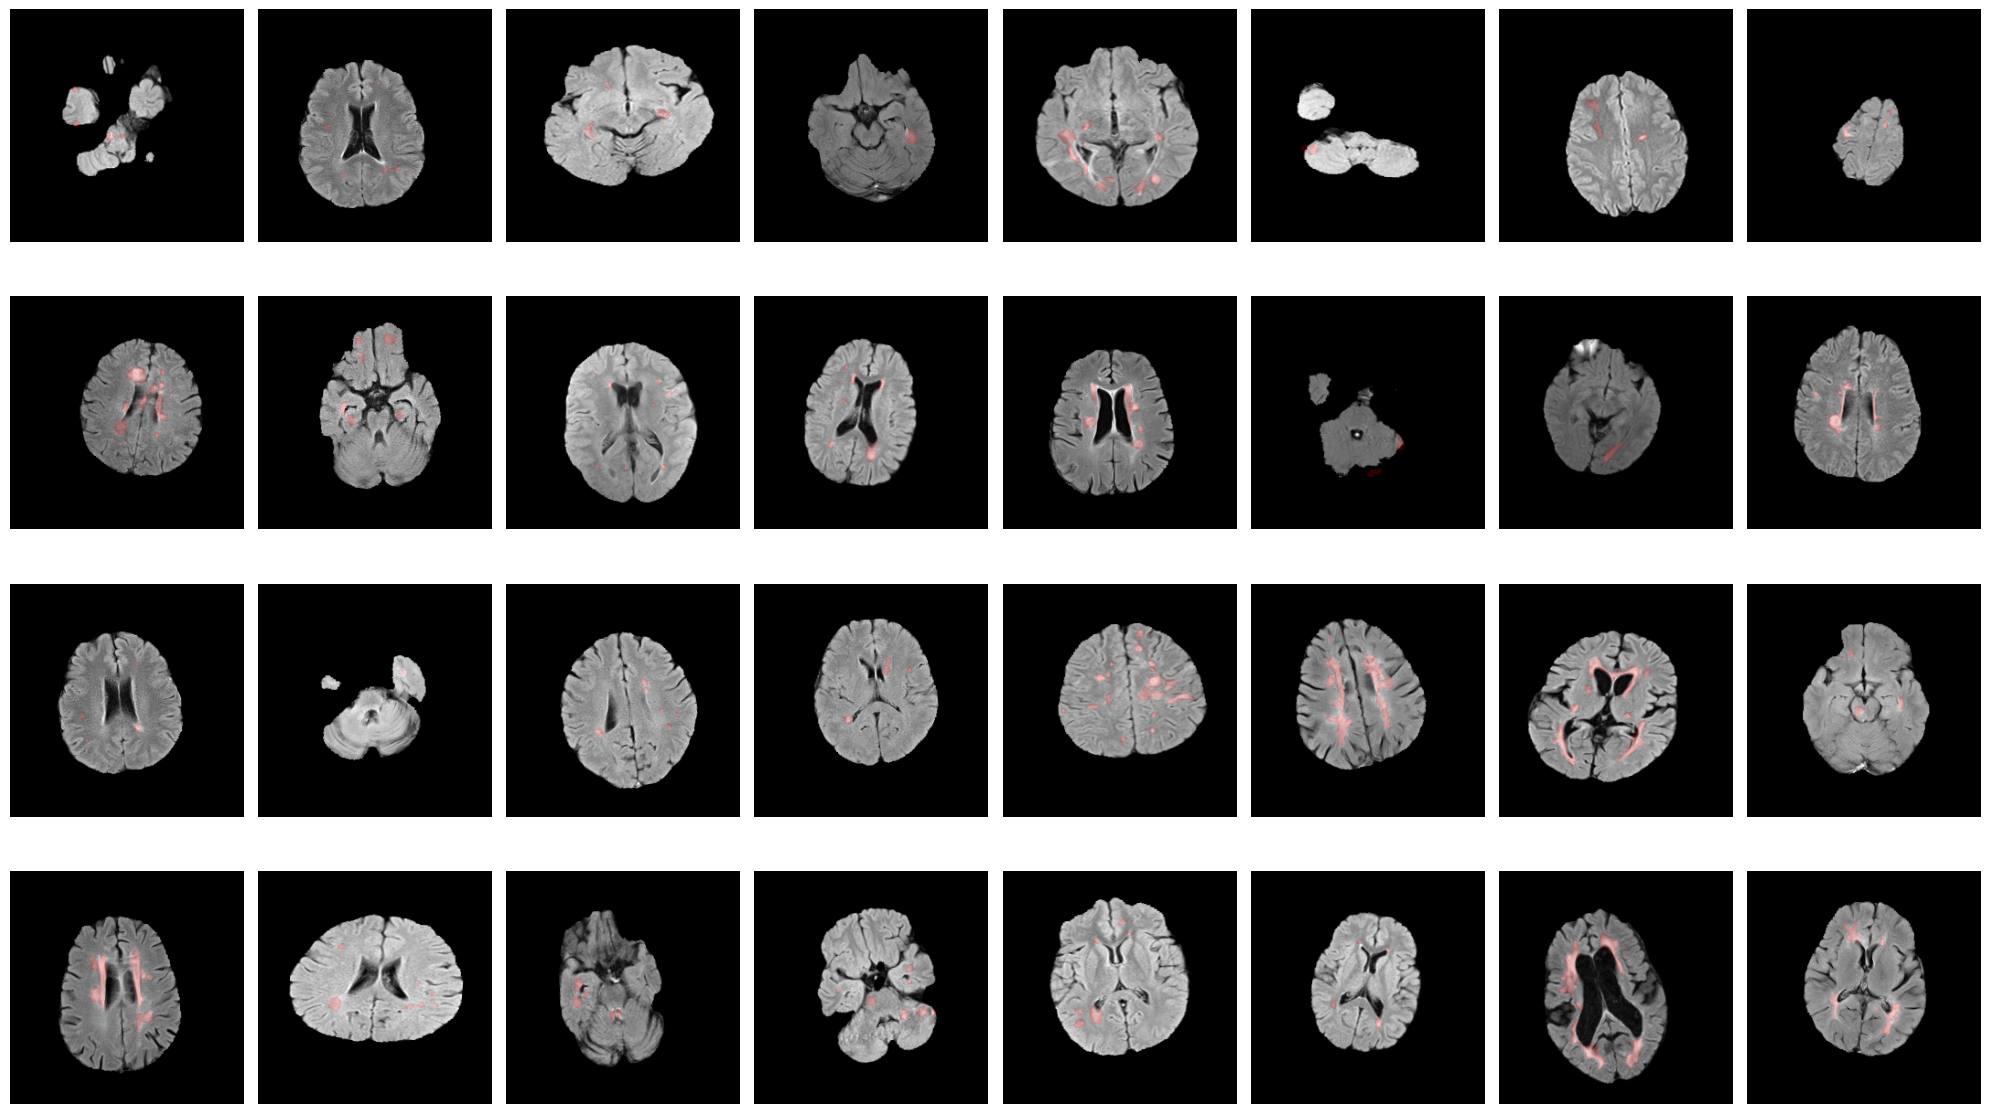

In [14]:
# Display augmented batches to check mask alignment
for n_batch in range(2):
    batch_slices, batch_masks = next(iterator_train)
    display_slices(batch_slices, batch_masks, alpha=0.2, rows=4)

# Model Training

In [15]:
from src.unetr_2d import build_unetr_2d

cf = {}
cf["image_size"] = 256
cf["num_channels"] = 1
cf["num_layers"] = 12
cf["hidden_dim"] = 128
cf["mlp_dim"] = 32
cf["num_heads"] = 6
cf["dropout_rate"] = 0.5
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)

model = build_unetr_2d(cf)

I0000 00:00:1728226261.205765  160635 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:25:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728226261.205850  160635 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:25:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728226261.205886  160635 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:25:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728226261.408367  160635 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:25:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728226261.408428  160635 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:25:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-06

In [ ]:
model.summary()

In [17]:
# import tensorflow as tf
# 
# tf.get_logger().setLevel('WARNING') # Suppress TensorFlow info messages
# 
# # Create and compile the model
# model = build_unet_resnet50(input_shape=(256, 256, 1))
# # model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4),
              loss=dice_loss,
              metrics=[dice_coefficient])

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model_l2_reg.keras', save_best_only=True, monitor='val_dice_coefficient', mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_coefficient', factor=0.1, patience=5, mode='max'),
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coefficient', patience=10, mode='max', restore_best_weights=True)
]

# Train the model
history = model.fit(
    iterator_train,
    steps_per_epoch=len(all_slices_train) // BATCH_SIZE,
    validation_data=iterator_val,
    validation_steps=len(all_slices_val) // BATCH_SIZE,
    epochs=50,
    callbacks=callbacks
)

# Evaluate the model
evaluation = model.evaluate(iterator_val, steps=len(all_slices_val) // BATCH_SIZE)
print(f"Validation Loss: {evaluation[0]}")
print(f"Validation Dice Coefficient: {evaluation[1]}")

Epoch 1/50


I0000 00:00:1728226272.718542  161177 service.cc:146] XLA service 0x7f94d40102d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728226272.718586  161177 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-10-06 16:51:13.242209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-06 16:51:14.415949: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-06 16:51:23.984187: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[32,16,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,128,128]{3,2,1,0}, f32[32,16,2,2]{3,2,1,0}), window={size=2x2 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_op

13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - dice_coefficient: 0.0072 - loss: 0.9928

E0000 00:00:1728226324.194401  161175 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot training history
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot dice coefficients
ax2.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
ax2.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
ax2.set_title('Dice Coefficient')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Dice Coefficient')
ax2.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
all_preds = model.predict(all_slices_val)
all_preds_binary = np.where(all_preds > 0.5, 1, 0)

Display the predictions for all validation slices
- Red: Lesion mask (ground truth)
- Blue: Predicted lesion
- Yellow: Overlap

In [ ]:
display_slices(all_slices_val, all_masks_val, all_preds_binary, alpha=0.7, rows=20)

In [ ]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(all_preds.flatten(), bins=50, range=(0, 1), edgecolor='black')

plt.title('Histogram of Prediction Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()